# Language Modeling: PyTorch

[Reference](https://www.kdnuggets.com/2020/07/pytorch-lstm-text-generation-tutorial.html)

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import pandas as pd
from tqdm import tqdm
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt
import time, os, copy, pickle, string
from collections import Counter

/home/arjun/anaconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print(f"torch version: {torch.__version__}")

torch version: 1.11.0


In [4]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080


In [5]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cuda


In [6]:
# Specify hyper-parameters
batch_size = 256
num_epochs = 100

### Data pre-processing

- ```Dataset``` class inherits from the PyTorch's ```torch.utils.data.Dataset``` class and defines two important methods ```__len__``` and ```__getitem__```.

- ```load_words()``` function loads the dataset. Unique words are calculated in the dataset to define the size of the network's vocabulary and embedding size. ```index_to_word()``` and ```word_to_index()``` converts words to number indexes and visa versa.

- This is part of the process is known as __tokenization__. In the future, ```torchtext``` team plan to improve this part, but they are re-designing it and the new API is too unstable for this tutorial as of today.

[PyTorch data loading tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class)

#### Shakespeare text file is large and causes CUDA OOM error! So, a much smaller text corpus is used instead.

In [ ]:
'''
# Read in txt file containing dataset-
with open('shakespeare_text.txt', 'r', encoding = 'utf-8') as file:
    file = file.readlines()
'''

In [ ]:
# print(f"number of lines in dataset = {len(file)}")
# number of lines in dataset = 40000

In [ ]:
# First two lines-
# file[:2]

In [ ]:
# Replace newline with <EOS> token-
# file[0].replace("\r", "<EOS>").replace("\n", "<EOS>")

In [8]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self, sequence_length
    ):
        # self.file_corpus = file_corpus
        self.sequence_length = sequence_length
        self.words = self.load_words()
        self.uniq_words = self.get_uniq_words()

        # Convert number indices to words-
        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        
        # Convert word to number indices-
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}

        self.words_indexes = [self.word_to_index[w] for w in self.words]

    def load_words(self):
        train_df = pd.read_csv('reddit_cleanjokes.csv')
        text = train_df['Joke'].str.cat(sep = ' ')
        return text.split(' ')
        '''
        text = "".join(v for v in self.file_corpus if v not in string.punctuation).lower()
        text = text.encode("utf-8").decode("ascii", "ignore")
        return text.split(' ')
        '''

    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return sorted(
            word_counts, key = word_counts.get,
            reverse = True
        )

    def __len__(self):
        # return len(self.words_indexes) - self.args.sequence_length
        return len(self.words_indexes) - self.sequence_length

    def __getitem__(self, index):
        return (
            torch.tensor(self.words_indexes[index : index + self.sequence_length]),
            torch.tensor(self.words_indexes[index+1 : index + self.sequence_length + 1]),
        )
    

In [ ]:
# Compute maximum sequence length for a given text corpus-
# max_sequence_len = max([len(x) for x in file])
# print(f"maximum sequence length in the given training text corpus = {max_sequence_len}")

In [9]:
# Using low sequence length due to CUDA OOM error problems-
sequence_length = 10

In [10]:
# Get torch dataset-
dataset = Dataset(sequence_length = sequence_length)

In [11]:
print(f"number of words in dataset = {len(dataset.words)}")

number of words in dataset = 23914


In [12]:
# Define dataloader-
dataloader = DataLoader(
    dataset = dataset, batch_size = batch_size
)

In [13]:
# Sanity check-
x = next(iter(dataloader))

In [14]:
len(x), x[0].shape, x[1].shape

(2, torch.Size([256, 10]), torch.Size([256, 10]))

In [15]:
del x

### Define _Language Modeling Seq2Seq_ architecture

This is a standard looking PyTorch model.

- __```Embedding``` layer converts word indexes to word vectors__.

- LSTM is the main learnable part of the network - PyTorch implementation has the gating mechanisms implemented inside the LSTM cell that can learn long sequences of data.

- RNNs and LSTMs have extra state information they carry between training episodes.

- ```forward()``` function has a ```prev_state``` argument. This state is kept outside the model and passed manually.

- It also has ```init_state()``` function. Calling this at the start of every epoch to initializes the right shape of the state.

In [16]:
class LSTM_Model(nn.Module):
    def __init__(
        self, dataset,
        lstm_size = 128, embedding_dim = 128,
        num_layers = 3
    ):
        super(LSTM_Model, self).__init__()
        self.lstm_size = lstm_size
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        # Count number of unique words in vocabulary/dictionary-
        n_vocab = len(dataset.uniq_words)
        
        self.embedding = nn.Embedding(
            num_embeddings = n_vocab,
            embedding_dim = self.embedding_dim,
        )
        self.lstm = nn.LSTM(
            input_size = self.lstm_size,
            hidden_size = self.lstm_size,
            num_layers = self.num_layers,
            dropout = 0.2,
        )
        self.fc = nn.Linear(in_features = self.lstm_size, out_features = n_vocab)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)
        return logits, state

    def init_state(self, sequence_length):
        return (
            torch.zeros(self.num_layers, sequence_length, self.lstm_size),
            torch.zeros(self.num_layers, sequence_length, self.lstm_size)
        )
    

In [17]:
# Initialize LSTM model-
model = LSTM_Model(
    dataset = dataset, lstm_size = 128,
    embedding_dim = 128, num_layers = 2
).to(device)

In [18]:
tot_params = 0

# Print layer names-
for layer in model.state_dict().keys():
    print(f"{layer} has dimension = {model.state_dict()[layer].cpu().detach().numpy().shape}")
    tot_params += model.state_dict()[layer].cpu().numpy().size

embedding.weight has dimension = (6925, 128)
lstm.weight_ih_l0 has dimension = (512, 128)
lstm.weight_hh_l0 has dimension = (512, 128)
lstm.bias_ih_l0 has dimension = (512,)
lstm.bias_hh_l0 has dimension = (512,)
lstm.weight_ih_l1 has dimension = (512, 128)
lstm.weight_hh_l1 has dimension = (512, 128)
lstm.bias_ih_l1 has dimension = (512,)
lstm.bias_hh_l1 has dimension = (512,)
fc.weight has dimension = (6925, 128)
fc.bias has dimension = (6925,)


In [19]:
print(f"Total number of trainable parameters = {tot_params}")

Total number of trainable parameters = 2043917


### Multi-GPU Training in PyTorch

- [Multi-GPU Examples](https://pytorch.org/tutorials/beginner/former_torchies/parallelism_tutorial.html)

- [Data Parallelism](https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html)

In [ ]:
# Use all available GPUs-
# model = nn.DataParallel(model)
# model.to(device)

In [20]:
# Define loss function-
loss_criterion = nn.CrossEntropyLoss()

# Define SGD optimizer-
# optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr = 10e-3)

In [21]:
# Python3 dict to contain metrics-
train_history = {}

In [22]:
def train(model, train_loader):
    '''
    Function to train model for specified number of epochs.
    '''
    
    # Set model to train-
    model.train()
    
    best_loss = 100
    
    for epoch in range(1, num_epochs + 1):
        state_h, state_c = model.init_state(sequence_length)
        state_h = state_h.to(device)
        state_c = state_c.to(device)
        
        for batch, (x, y) in enumerate(train_loader):
            
            x = x.to(device)
            y = y.to(device)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Make LSTM predictions-
            y_pred, (state_h, state_c) = model(x, (state_h, state_c))
            
            # Compute cross-entropy loss-
            loss = loss_criterion(y_pred.transpose(1, 2), y)
            
            state_h = state_h.detach()
            state_c = state_c.detach()
            
            # Perform backprop-
            loss.backward()
            
            # Update parameters-
            optimizer.step()
            
        # Save best weights achieved until now-
        if (loss.item() < best_loss):
            # update 'best_loss' variable to lowest loss encountered so far-
            best_loss = loss.item()

            print(f"Saving model with lowest loss = {loss.item():.5f}\n")
        
            # Save trained model with 'best' loss-
            torch.save(model.state_dict(), "Language_Model_best_model.pth")
        
        print(f"epoch: {epoch}, loss = {loss.item():.5f}\n")
        train_history[epoch] = loss.item()


In [23]:
# Train model-
train(model = model, train_loader = dataloader)

Saving model with lowest loss = 6.62055

epoch: 1, loss = 6.62055

Saving model with lowest loss = 5.74857

epoch: 2, loss = 5.74857

Saving model with lowest loss = 5.31697

epoch: 3, loss = 5.31697

Saving model with lowest loss = 4.94646

epoch: 4, loss = 4.94646

Saving model with lowest loss = 4.49212

epoch: 5, loss = 4.49212

Saving model with lowest loss = 3.84875

epoch: 6, loss = 3.84875

Saving model with lowest loss = 3.53967

epoch: 7, loss = 3.53967

Saving model with lowest loss = 3.22572

epoch: 8, loss = 3.22572

Saving model with lowest loss = 2.61579

epoch: 9, loss = 2.61579

Saving model with lowest loss = 2.44946

epoch: 10, loss = 2.44946

Saving model with lowest loss = 2.09015

epoch: 11, loss = 2.09015

Saving model with lowest loss = 1.90077

epoch: 12, loss = 1.90077

Saving model with lowest loss = 1.65849

epoch: 13, loss = 1.65849

Saving model with lowest loss = 1.46817

epoch: 14, loss = 1.46817

Saving model with lowest loss = 1.29430

epoch: 15, loss 

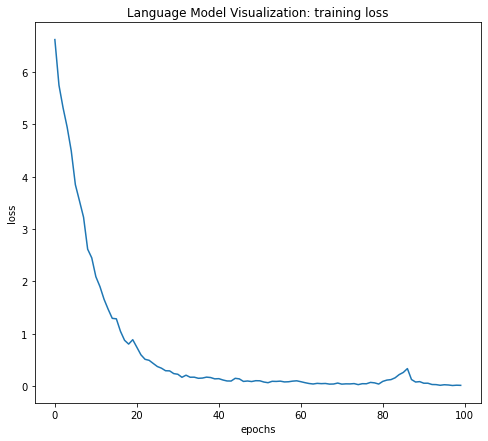

In [26]:
# Visualize training-
plt.figure(figsize = (8, 7))
plt.plot([train_history[epoch] for epoch in train_history.keys()])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Language Model Visualization: training loss")
plt.show()

In [27]:
def predict(model, dataset, text, next_words = 100):
    '''
    Synthesize new sequences using 'text' as input.
    '''

    model.eval()

    words = text.split(' ')
    state_h, state_c = model.init_state(len(words))
    state_h = state_h.to(device)
    state_c = state_c.to(device)

    for i in range(0, next_words):
        x = torch.tensor([[dataset.word_to_index[w] for w in words[i:]]])
        x = x.to(device)
        y_pred, (state_h, state_c) = model(x, (state_h, state_c))

        last_word_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_word_logits, dim = 0).cpu().detach().numpy()
        word_index = np.random.choice(len(last_word_logits), p = p)
        words.append(dataset.index_to_word[word_index])

    return words

In [28]:
# Generate new words using trained model-
synthesized_words = predict(model = model, dataset = dataset,
        text = 'Knock knock. Whos there?', next_words = 5
       )

In [29]:
synthesized_words

['Knock', 'knock.', 'Whos', 'there?', 'cables?', 'You', 'better', 'not', 'try']

In [ ]:
'''
# Load trained model-
trained_model = LSTM_Model(
    dataset = dataset, lstm_size = 128,
    embedding_dim = 128, num_layers = 2
).to(device)

trained_model.load_state_dict(torch.load("Language_Model_best_model.pth"))
'''

### Next steps:


- Clean up the data by removing non-letter characters.

- Increase the model capacity by adding more Linear or LSTM layers.

- Split the dataset into train, test, and validation sets.

- Add checkpoints so you don't have to train the model every time you want to run prediction.